# 3. Estimate Camera Pose using an Aruco marker

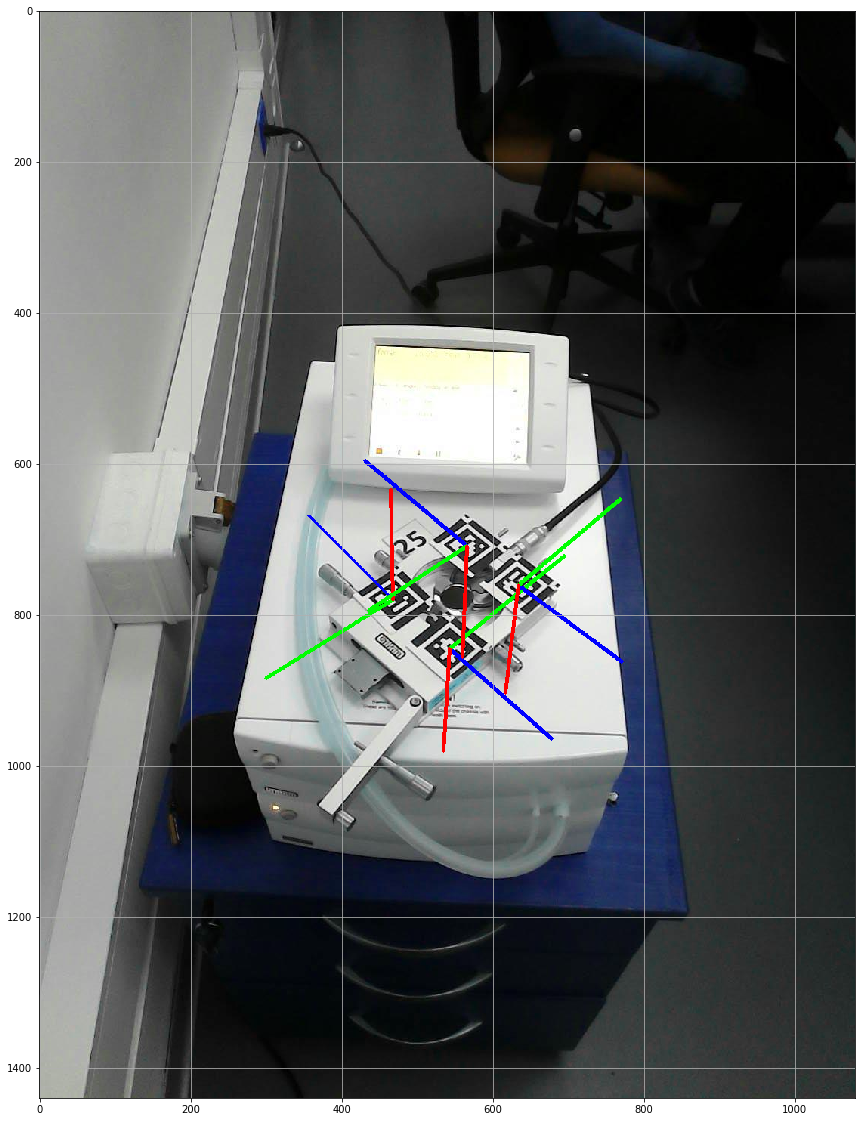

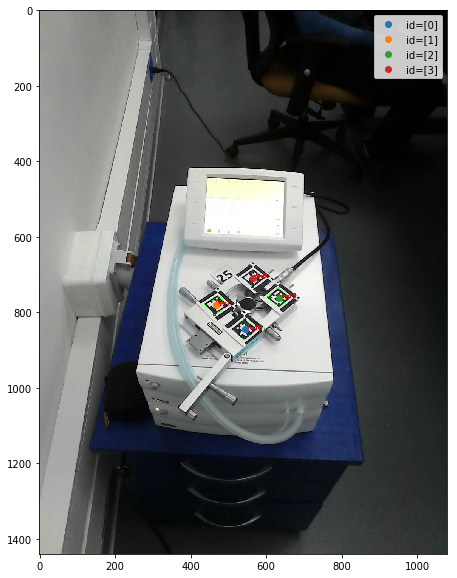

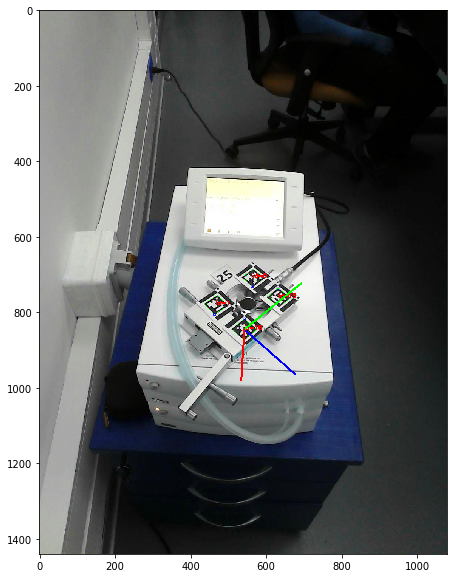

In [81]:
img_path = "G:/Mi unidad/8. PhD/3. Experimentos/2. Thermography/2. TemperatureMeasurements StageRAMAN/2. ExperimentosControlados/Fotos/RGB Images/UFEK4895- full photo.JPG"
frame = cv2.imread(img_path)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                      parameters=parameters)

# Define size of the aruco markers in chessboard-Charuco
size_of_marker =  0.023 # side lenght of the marker in meter
rvecs,tvecs, _ = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)



imaxis = frame.copy()
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
fig = plt.figure(figsize=(20,20))
#plt.figure()
plt.imshow(imaxis)
plt.grid()
plt.show()


# Draw center of markers
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
fig = plt.figure(figsize=(10,10))
plt.imshow(frame_markers)
for i in range(len(ids)):
    c = corners[i][0]
    #plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
    plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format([i]))
plt.legend()
plt.show()
 

# Draw detected aruco 
length_of_axis = 0.1
i=0
imaxis = frame.copy()
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
fig = plt.figure(figsize=(10,10))
plt.imshow(imaxis)
plt.show()


# Calculate Camera-Object Distances

In [69]:
# Calculate distance from center of Aruco Marker to Camera (in centimeters).
# Multiple distances are shown when multiple aruco markers are detectd.
for i in range(len(tvecs)):
    from scipy.spatial import distance
    print(distance.euclidean(tvecs[i], 0)*100) #Multiplied by 100 to convert from meters to centimeters.


61.64256658381264
62.967104874826184
64.44078767256099
65.64099389329984


# Calculate Rotation (over Z, Y and X axis)

In [70]:
#A vector of rotation in Z,Y and X is shown for each one of the aruco markers
import math
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) : 
    assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

# Computing rotation matrix
def VectorToRotationMatrix(rvecs) : 
    rotation_matrix_all = []
    degrees_eulervectors = []
    rotation_matrix = np.zeros(shape=(3,3))
    for i in range(len(rvecs)):
        cv2.Rodrigues(rvecs[i], rotation_matrix)
        rotation_matrix_all.append(rotation_matrix)
        eulervector = rotationMatrixToEulerAngles(rotation_matrix) #ZYX
        degrees_eulervectors.append([math.degrees(f) for f in eulervector])
    rotation_matrix_all = rotation_matrix_all + rotation_matrix
    return degrees_eulervectors

degrees_eulervectors = np.array(VectorToRotationMatrix(rvecs))
degrees_eulervectors # Columna 1: Angulos de rotación en Z *ZYX

array([[-171.56298077,  -18.84827074,   47.45728891],
       [-134.07129239,  -28.30564454, -145.59706805],
       [-158.12582687,  -19.37967131,   40.42759134],
       [ 160.11204625,   29.95177045, -134.09544879]])

In [89]:
angles = np.minimum(180+degrees_eulervectors[:,0], 180-degrees_eulervectors[:,0])
print(angles)
angles.mean()
#np.percentile(angles,50)

[ 8.43701923 45.92870761 21.87417313 19.88795375]


24.031963429641074

In [90]:
angles = np.minimum(180+degrees_eulervectors[:,2], 180-degrees_eulervectors[:,2])
angles

array([132.54271109,  34.40293195, 139.57240866,  45.90455121])

# Automatic calculation of Camera-Object Distance and Angles 

In [94]:
def distance_angle(file):
    import pandas as pd
    
    frame = cv2.imread(file)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                          parameters=parameters)

    # Define size of the aruco markers in chessboard-Charuco
    size_of_marker =  0.023 # side lenght of the marker in meter
    rvecs,tvecs, _ = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

    
    distances = []
    # Calculate distance from center of Aruco Marker to Camera (in centimeters).
    # Multiple distances are shown when multiple aruco markers are detectd.
    for i in range(len(tvecs)):
        from scipy.spatial import distance
        distances.append(distance.euclidean(tvecs[i], 0)*100)  #Multiplied by 100 to convert from meters to centimeters.
        
    # Get list of angles of CharUco Markers 
    est_angles = []
    degrees_eulervectors = VectorToRotationMatrix(rvecs)    
    for i in range(len(degrees_eulervectors)):
        est_angles.append(degrees_eulervectors[i][0]) # Columna 1: Angulos de rotación en Z
    
    # Get name of the file. 
    loc_fotos = file.find("Fotos/T")
    tempe = file[(loc_fotos+7):(loc_fotos+9)]
    imgname = file[(loc_fotos+10):]
    imgname = imgname[:imgname.find("- full photo.JPG")]
    
    out = pd.DataFrame(
    {'file': imgname,
     'temperature': tempe,
     'distances': distances,
     'angles': est_angles
    })
    
    return(out)
 
#Example :
#file = "G:/Mi unidad/8. PhD/Experimentos/Exper2_StageTemp/Fotos/T25/CSJX4307- full photo.JPG"
#out = distance_angle(file)
#out

In [95]:
datadir =  "G:/Mi unidad/8. PhD/3. Experimentos/2. Thermography/2. TemperatureMeasurements StageRAMAN/2. ExperimentosControlados/Fotos/RGB Images/"
#list_images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith("full photo.JPG") ]) # files within folder
list_images = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(datadir)) for f in fn if f.endswith("full photo.JPG")] # recursive
out = pd.DataFrame()
for i in range(len(list_images)):
    file = list_images[i]
    out_temp = distance_angle(file)
    out = out.append(out_temp)        
    
out.head(); out["temperature"].value_counts()

un    763
Name: temperature, dtype: int64

In [18]:
out.to_csv(datadir+"Output_distances_and_angles.csv",index=False)